In [1]:
# !pip install transformers datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**ARABERT Classification**

In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from transformers import AutoTokenizer


**Data Loading and Label Assignment** <br>

For this project, I'm using the MADAR (Multi-Arabic Dialect Applications and Resources) dataset, which is a key resource for working with Arabic dialects. The MADAR project, a collaboration between CMU-Q, NYUAD, Columbia University, and the University of Bahrain, aimed to improve how we process dialectal Arabic by creating resources like a 25-city multi-dialect lexicon and parallel corpus.

In my project, I’m specifically using data from 5 cities: Beirut, Cairo, Doha, Rabat, and Tunis. This dataset provides a rich collection of dialectal Arabic text from these cities, making it perfect for building models that can identify and distinguish between these specific Arabic dialects. By leveraging this dataset, I'm able to train models like AraBERT and BERT, and even compare their performance against general-purpose models like GPT-4 and GPT-4O, to see how well they handle the complex task of dialect classification.

This dataset is crucial for my project because it offers the depth and diversity needed to develop robust models that can generalize across these different Arabic dialects.


<br>
This cell is responsible for loading the training and test datasets from specified file paths and assigning labels to each dataset. The data is loaded from .tsv files corresponding to different Arabic dialects, and each dialect is assigned a unique label. <br>


*   <b>Data Loading:</b> The load_data function reads the datasets for different Arabic dialects using pandas.read_csv. Each dataset is labeled based on its position in the train_paths and test_paths lists.
*   <b>Label Assignment:</b> Labels are assigned to each dataset, where the label corresponds to the index of the dialect in the file paths list.
*   <b>Data Concatenation:</b> The datasets for all dialects are concatenated into a single DataFrame for both training and test data.




In [4]:
def load_data(train_paths, test_paths):
    train_data = []
    for label, path in enumerate(train_paths):
        df = pd.read_csv(path, sep='\t')
        df['label'] = label
        train_data.append(df[['CODA', 'label']])

    test_data = []
    for label, path in enumerate(test_paths):
        df = pd.read_csv(path, sep='\t')
        df['label'] = label
        test_data.append(df[['CODA', 'label']])

    return pd.concat(train_data), pd.concat(test_data)

train_paths = [
    '/content/drive/MyDrive/madar/train/train.Beirut.tsv',
    '/content/drive/MyDrive/madar/train/train.Cairo.tsv',
    '/content/drive/MyDrive/madar/train/train.Doha.tsv',
    '/content/drive/MyDrive/madar/train/train.Rabat.tsv',
    '/content/drive/MyDrive/madar/train/train.Tunis.tsv'
]

test_paths = [
    '/content/drive/MyDrive/madar/test/test.Beirut.tsv',
    '/content/drive/MyDrive/madar/test/test.Cairo.tsv',
    '/content/drive/MyDrive/madar/test/test.Doha.tsv',
    '/content/drive/MyDrive/madar/test/test.Rabat.tsv',
    '/content/drive/MyDrive/madar/test/test.Tunis.tsv'
]

train_df, test_df = load_data(train_paths, test_paths)


The train_df and test_df DataFrames are created, containing the CODA (Conventional Orthography for Dialectal Arabic) text and corresponding labels for each dialect.

In [ ]:
train_df.head()

,CODA,label
0,انا باعطيك رقم تلفونه وعنوانه.,0
1,فيك تغير لي مقعدي؟,0
2,اسمك مرة ثاني؟,0
3,في محل شامل قريب من هون؟,0
4,هالباص بيروح عاوتيل الشيراتون؟,0


**Tokenization** <br>
Tokenization converts the raw text data into a format that the model can process. <br>
*   <b>Tokenization:</b> The arabert_tokenizer is applied to the CODA text in the train_df and test_df DataFrames. The tokenizer truncates sequences that exceed a maximum length (max_length=128) and pads shorter sequences to ensure uniform input size.
*   <b> Output:</b> The tokenized outputs are stored in train_encodings and test_encodings, which are used for model training and evaluation.




In [ ]:
from transformers import logging
logging.set_verbosity_error()

arabert_MODEL = "aubmindlab/bert-base-arabertv2"
arabert_tokenizer = AutoTokenizer.from_pretrained(arabert_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
train_encodings = arabert_tokenizer(train_df['CODA'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = arabert_tokenizer(test_df['CODA'].tolist(), padding=True, truncation=True, max_length=128)


NameError: name 'arabert_tokenizer' is not defined

initializes the pre-trained AraBERT model for sequence classification <br>
* <b>Custom Dataset Class:</b> The ArabicDialectDataset class is defined to create a PyTorch-compatible dataset from the tokenized encodings and labels. This class allows the model to iterate over the data during training and evaluation.
* <b>Label Preparation:</b> The labels for the training and test data are extracted and stored in train_labels and test_labels.
* <b>Dataset Creation:</b> Instances of ArabicDialectDataset are created for both the training and test datasets.
* <b>Model Initialization:</b> The AraBERT model (`aubmindlab/bert-base-arabertv2`) is loaded and configured for sequence classification, with the number of labels set to 5, corresponding to the five Arabic dialects.


In [ ]:
class ArabicDialectDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_labels = train_df['label'].tolist()
test_labels = test_df['label'].tolist()

train_dataset = ArabicDialectDataset(train_encodings, train_labels)
test_dataset = ArabicDialectDataset(test_encodings, test_labels)

arabert_model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=5)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

compute metrics

The accuracy, precision, recall, and f1 metrics are loaded using the evaluate library.


In [ ]:
import evaluate
import numpy as np

# Load the metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

# Define the compute_metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute the metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    # Compute the confusion matrix

    # Optionally, you could return the confusion matrix as part of the metrics

    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1'],
    }


* **Data Collator:** A DataCollatorWithPadding is instantiated to ensure that the input sequences are padded to the same length within each batch during training.
* **Training Arguments:** The TrainingArguments object is configured to specify key training parameters, such as learning rate, batch size, number of epochs, evaluation strategy, logging strategy, and checkpoint saving strategy.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=arabert_tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Increase the number of epochs as needed
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Ensure evaluation is performed after each epoch
    logging_strategy="epoch",     # Ensure training loss is logged at the end of each epoch
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,  # Automatically load the best model at the end
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    save_total_limit=1,  # Keep only the best model checkpoint
    logging_dir='./logs',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


* **Trainer Initialization:** The Trainer object is instantiated, linking the model, training arguments, datasets, tokenizer, data collator, and the custom metrics function.
* **Integration:** The Trainer integrates all the components and is ready to manage the training and evaluation of the model.

In [ ]:
arabert_trainer = Trainer(
    model=arabert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=arabert_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

**Training Progress:**

While training, the model’s loss and metrics are tracked, and the best version gets saved based on how it performs during evaluations.

So, as the training went on, the model’s loss kept dropping—from 0.9927 in the first epoch down to 0.1438 by the last one. That’s a pretty solid sign that the model was actually learning from the data. By the end, the average training loss was 0.3867, which is a big improvement from where it started, meaning the model got the hang of the patterns in the data.

**Evaluation Performance:**

At first, the evaluation loss (basically how well it does on new data) was going down and hit its lowest point around the 4th epoch. But after that, it started to creep up a bit. This usually happens when the model starts to overfit, meaning it’s getting too cozy with the training data and not doing as well on new stuff. But on the upside, accuracy, precision, recall, and F1-score kept getting better throughout the training. For example, accuracy went from 0.7318 to 0.8114, so it was definitely getting better at handling new data.

**Model Performance and Overfitting:**

The slight bump in evaluation loss after the 4th epoch, even though accuracy and F1-score kept improving, hints that there might be a bit of overfitting going on. But it’s nothing too serious—the model is still doing a good job. By the end, it hit an F1-score of 0.8119, which shows it’s pretty balanced between precision and recall, making it reliable for classifying different dialects.

**Efficiency and Computation:**

The model processes a lot of samples and steps per second, so it’s using resources efficiently. And the total training time of around 889.54 seconds for 10 epochs is pretty reasonable for a model like this.

**Conclusion:**

All in all, the model did a great job, with metrics steadily improving throughout the training. While there’s a little bit of overfitting, it’s not a big deal—the model is well-suited for classifying dialects. With a bit more fine-tuning, it could probably get even better, but it’s already performing at a high level.

In [ ]:
arabert_trainer.train()

{'loss': 0.9927, 'grad_norm': 24.91621208190918, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 0.7537422180175781, 'eval_accuracy': 0.7318, 'eval_precision': 0.7529173244695316, 'eval_recall': 0.7318, 'eval_f1': 0.7324284723500143, 'eval_runtime': 15.6736, 'eval_samples_per_second': 319.007, 'eval_steps_per_second': 19.97, 'epoch': 1.0}
{'loss': 0.6451, 'grad_norm': 29.757354736328125, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 0.68864506483078, 'eval_accuracy': 0.7534, 'eval_precision': 0.8005290160225009, 'eval_recall': 0.7534, 'eval_f1': 0.7565138497394628, 'eval_runtime': 16.1084, 'eval_samples_per_second': 310.398, 'eval_steps_per_second': 19.431, 'epoch': 2.0}
{'loss': 0.4972, 'grad_norm': 2.822554588317871, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 0.5955226421356201, 'eval_accuracy': 0.7946, 'eval_precision': 0.7957004146443499, 'eval_recall': 0.7946, 'eval_f1': 0.7948234693202918, 'eval_runtime': 16.1823, 'eval_samples_per_second':

TrainOutput(global_step=3130, training_loss=0.3867171668396971, metrics={'train_runtime': 889.5417, 'train_samples_per_second': 56.209, 'train_steps_per_second': 3.519, 'train_loss': 0.3867171668396971, 'epoch': 10.0})

**Strong Performance:**

The model did a great job, hitting an accuracy of 0.8114 and an F1-score of 0.8120. This means it’s pretty solid at predicting the dialects correctly over 81% of the time on the validation set.

**Balanced Precision and Recall:**

The precision (0.8131) and recall (0.8114) are really close, which is a good sign. It shows that the model isn’t just accurate but also reliable, catching most of the true positives without throwing in too many false positives.

**Consistent Metrics:**

What’s cool is how consistent the accuracy, precision, recall, and F1-score are with each other. This balance means the model isn’t favoring one metric over another, which is super important in dialect classification, where getting the wrong answer can mess things up.

**Efficient Evaluation:**

The evaluation process was pretty quick, taking about 17 seconds, and the model handled a lot of data efficiently. This is a big deal, especially when working with large datasets, because it means you can run evaluations and fine-tune the model without wasting a ton of time.

**Conclusion:**

All in all, the model is doing a great job classifying Arabic dialects, with high marks in accuracy, precision, recall, and F1-score. The metrics are balanced, and it’s processing everything efficiently, making it ready for real-world use or some final tweaks if needed.

In [ ]:
results = arabert_trainer.evaluate()
print(results)


{'eval_loss': 0.7672391533851624, 'eval_accuracy': 0.8114, 'eval_precision': 0.8131338495159706, 'eval_recall': 0.8114, 'eval_f1': 0.8119814773244225, 'eval_runtime': 17.1976, 'eval_samples_per_second': 290.738, 'eval_steps_per_second': 18.2, 'epoch': 10.0}
{'eval_loss': 0.7672391533851624, 'eval_accuracy': 0.8114, 'eval_precision': 0.8131338495159706, 'eval_recall': 0.8114, 'eval_f1': 0.8119814773244225, 'eval_runtime': 17.1976, 'eval_samples_per_second': 290.738, 'eval_steps_per_second': 18.2, 'epoch': 10.0}


extracting logs

In [ ]:
logs = arabert_trainer.state.log_history

extracting metrics

In [ ]:

# Extracting the relevant information
train_loss = [log['loss'] for log in logs if 'loss' in log and 'epoch' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
train_epochs = list(range(1, len(train_loss) + 1))
eval_epochs = list(range(1, len(eval_loss) + 1))

print("Train Loss:", train_loss)
print("Eval Loss:", eval_loss)
print("Accuracy:", accuracy)
print("Train Epochs:", train_epochs)
print("Eval Epochs:", eval_epochs)


Train Loss: [0.9927, 0.6451, 0.4972, 0.4039, 0.3331, 0.268, 0.2252, 0.2003, 0.158, 0.1438]
Eval Loss: [0.7537422180175781, 0.68864506483078, 0.5955226421356201, 0.5952654480934143, 0.605553150177002, 0.6318274140357971, 0.6759511828422546, 0.7088524699211121, 0.7449761033058167, 0.7672391533851624, 0.7672391533851624]
Accuracy: [0.7318, 0.7534, 0.7946, 0.7996, 0.7986, 0.8062, 0.8064, 0.8076, 0.811, 0.8114, 0.8114]
Train Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Eval Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


loss

Throughout the training, the loss keeps dropping, which means the model is picking up on the patterns in the data and learning effectively. But there's a bit of a hiccup after the fourth epoch—while the evaluation loss initially goes down, it starts creeping back up, which is a red flag for overfitting. This means the model is getting too comfortable with the training data and isn’t generalizing as well to new, unseen data. The growing gap between the falling training loss and the rising evaluation loss after the fourth epoch is a clear sign that the model is becoming overly specialized. To tackle this, you might want to think about stopping the training early around the fourth epoch or using some regularization techniques to keep the model in check and improve how well it handles new data.

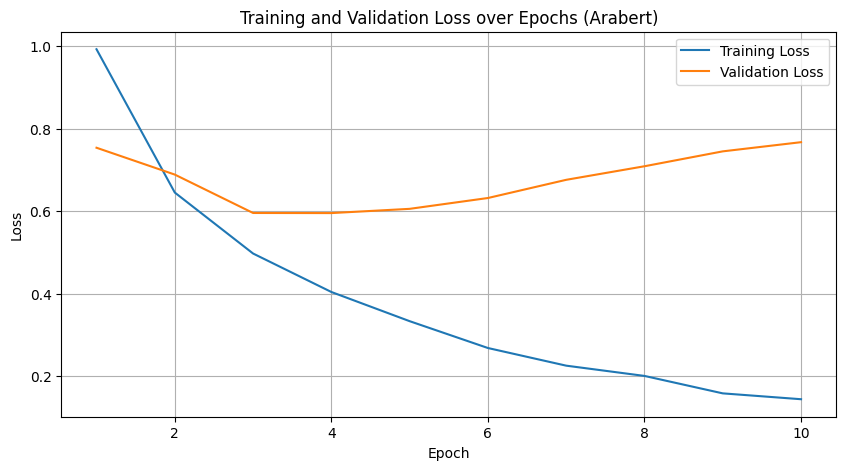

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label='Training Loss')
plt.plot(eval_epochs[:10], eval_loss[:10], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (Arabert)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/loss_curve_arabert.png")
plt.show()

accuracy

The accuracy keeps getting better with each epoch, starting at 73.18% and hitting 81.14% by the tenth epoch, which shows the model is learning and improving as it trains. But after the eighth epoch, the accuracy levels off, which suggests that pushing the training further doesn’t really boost accuracy much. This flattening out matches up with the earlier signs of overfitting we saw with the evaluation loss, reinforcing the idea that it might be a good idea to stop training earlier or use some regularization tricks to prevent overfitting and get the best performance out of the model.

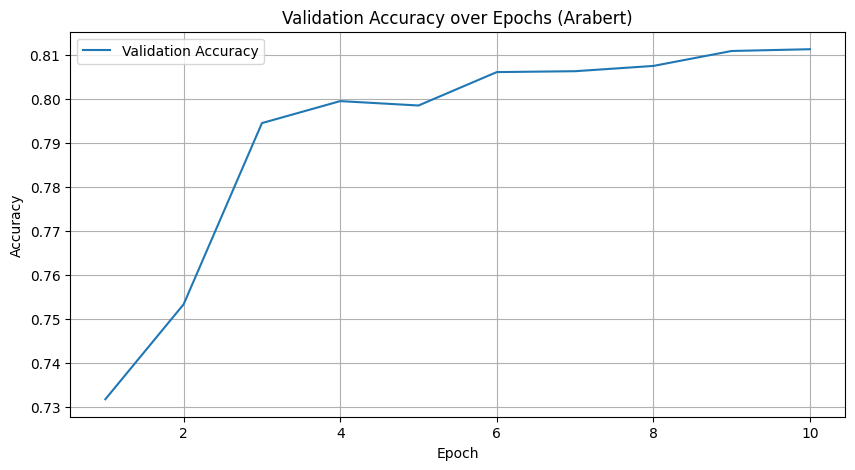

In [ ]:
# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs[:10], accuracy[:10], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (Arabert)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/accuracy_curve_arabert.png")
plt.show()


**BERT Fine-Tuning**

In [ ]:
bert_MODEL = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_MODEL)

train_encodings = bert_tokenizer(train_df['CODA'].tolist(), padding=True, truncation=True, max_length=128)
test_encodings = bert_tokenizer(test_df['CODA'].tolist(), padding=True, truncation=True, max_length=128)

train_labels = train_df['label'].tolist()
test_labels = test_df['label'].tolist()

train_dataset = ArabicDialectDataset(train_encodings, train_labels)
test_dataset = ArabicDialectDataset(test_encodings, test_labels)


bert_model = AutoModelForSequenceClassification.from_pretrained(bert_MODEL, num_labels=5)


bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

bert_training_args = TrainingArguments(
    output_dir="./results_bert",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",  # Log training loss at the end of every epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    logging_dir='./logs_bert',
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=bert_tokenizer,
    data_collator=bert_data_collator,
    compute_metrics=compute_metrics,
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fine-Tuning BERT

The training process shows a steady drop in both training loss (from 1.4141 to 0.2327) and evaluation loss, hitting a low around the 8th epoch before ticking up a bit, which hints at some overfitting in the last few epochs. The accuracy, precision, recall, and F1-score all get better as training goes on, with the model ending up with a 77.78% accuracy. This means the model learned effectively and generalized well to the validation data, but the slight bump in evaluation loss toward the end suggests that stopping the training a bit earlier—around the 8th or 9th epoch—might have helped avoid overfitting. Overall, the model did a solid job, with balanced precision and recall, showing it’s strong in classification tasks.

In [ ]:
bert_trainer.train()

{'loss': 1.4141, 'grad_norm': 17.01451301574707, 'learning_rate': 1.8e-05, 'epoch': 1.0}
{'eval_loss': 1.0514609813690186, 'eval_accuracy': 0.5922, 'eval_precision': 0.6218675036917073, 'eval_recall': 0.5922, 'eval_f1': 0.5971889468108665, 'eval_runtime': 35.7427, 'eval_samples_per_second': 139.889, 'eval_steps_per_second': 8.757, 'epoch': 1.0}
{'loss': 0.8894, 'grad_norm': 17.79067039489746, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}
{'eval_loss': 0.7828323841094971, 'eval_accuracy': 0.692, 'eval_precision': 0.6968253791676878, 'eval_recall': 0.692, 'eval_f1': 0.693061538071897, 'eval_runtime': 36.3865, 'eval_samples_per_second': 137.414, 'eval_steps_per_second': 8.602, 'epoch': 2.0}
{'loss': 0.6832, 'grad_norm': 7.637257099151611, 'learning_rate': 1.4e-05, 'epoch': 3.0}
{'eval_loss': 0.7310448288917542, 'eval_accuracy': 0.7306, 'eval_precision': 0.7351749357707849, 'eval_recall': 0.7306, 'eval_f1': 0.7322417939827668, 'eval_runtime': 36.4896, 'eval_samples_per_second': 13

TrainOutput(global_step=3130, training_loss=0.560304065253407, metrics={'train_runtime': 1551.0687, 'train_samples_per_second': 32.236, 'train_steps_per_second': 2.018, 'train_loss': 0.560304065253407, 'epoch': 10.0})

The evaluation results show that the model hit solid numbers across the board, with accuracy, precision, recall, and F1-score all hovering around 77.78%. The evaluation loss is fairly low at 0.795, which means the model is doing a decent job. The fact that precision, recall, and F1-score are all consistent suggests the model’s predictions are reliable. Plus, it’s running efficiently during evaluation, so it’s not just accurate but also quick at processing. Overall, the model is performing well, but there’s definitely some room to boost accuracy and generalization.

In [ ]:
results_bert = bert_trainer.evaluate()
print(results_bert)


{'eval_loss': 0.795375406742096, 'eval_accuracy': 0.7778, 'eval_precision': 0.7774598725575225, 'eval_recall': 0.7778, 'eval_f1': 0.7772383439025871, 'eval_runtime': 36.2093, 'eval_samples_per_second': 138.086, 'eval_steps_per_second': 8.644, 'epoch': 10.0}
{'eval_loss': 0.795375406742096, 'eval_accuracy': 0.7778, 'eval_precision': 0.7774598725575225, 'eval_recall': 0.7778, 'eval_f1': 0.7772383439025871, 'eval_runtime': 36.2093, 'eval_samples_per_second': 138.086, 'eval_steps_per_second': 8.644, 'epoch': 10.0}


In [ ]:
logs_bert = bert_trainer.state.log_history

# Extract training loss for epochs where it was logged
train_loss_bert = [log_bert['loss'] for log_bert in logs_bert if 'loss' in log_bert and 'epoch' in log_bert]

# Extract evaluation loss and accuracy
eval_loss_bert = [log_bert['eval_loss'] for log_bert in logs_bert if 'eval_loss' in log_bert]
accuracy_bert = [log_bert['eval_accuracy'] for log_bert in logs_bert if 'eval_accuracy' in log_bert]

# Create lists of epoch numbers based on the length of the extracted metrics
train_epochs_bert = list(range(1, len(train_loss_bert) + 1))
eval_epochs_bert = list(range(1, len(eval_loss_bert) + 1))


print("Train Loss:", train_loss_bert)
print("Eval Loss:", eval_loss_bert)
print("Accuracy:", accuracy_bert)
print("Train Epochs:", train_epochs_bert)
print("Eval Epochs:", eval_epochs_bert)

Train Loss: [1.4141, 0.8894, 0.6832, 0.5657, 0.4847, 0.4099, 0.3518, 0.2969, 0.2746, 0.2327]
Eval Loss: [1.0514609813690186, 0.7828323841094971, 0.7310448288917542, 0.6695125102996826, 0.6721652150154114, 0.7045974731445312, 0.7514856457710266, 0.7590123414993286, 0.7829289436340332, 0.795375406742096, 0.795375406742096]
Accuracy: [0.5922, 0.692, 0.7306, 0.7544, 0.757, 0.7638, 0.7642, 0.772, 0.7754, 0.7778, 0.7778]
Train Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Eval Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


The training loss steadily drops with each epoch, showing that the model is learning effectively. At first, the evaluation loss also goes down, hitting its lowest point around the fourth epoch, but then it starts creeping back up, which is a sign that overfitting might be kicking in. The fact that evaluation loss increases after the fourth epoch, even though training loss keeps going down, suggests the model is starting to memorize the training data instead of generalizing well to new data. Stopping the training around the fourth or fifth epoch could have helped avoid overfitting and kept the model’s generalization on track. Overall, the model learns well but has some trouble generalizing as training goes on.

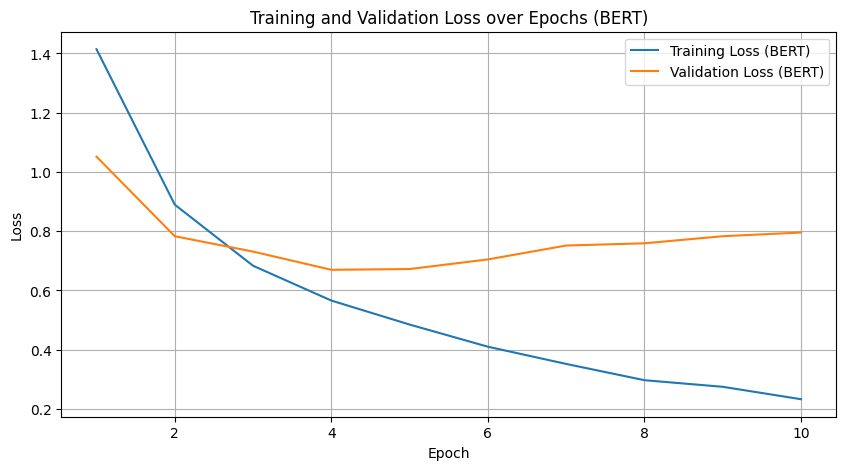

In [ ]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_epochs_bert, train_loss_bert, label='Training Loss (BERT)')
plt.plot(eval_epochs_bert[:10], eval_loss_bert[:10], label='Validation Loss (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (BERT)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/loss_curve_bert.png")
plt.show()

The accuracy steadily climbs from 59.22% to 77.78% by the tenth epoch, showing the model is learning well. After the eighth epoch, the accuracy levels off, suggesting it’s nearing its peak performance. The small gains in the last few epochs indicate that further training might not add much and could even lead to overfitting, so stopping around the eighth or ninth epoch might have been ideal for better generalization.

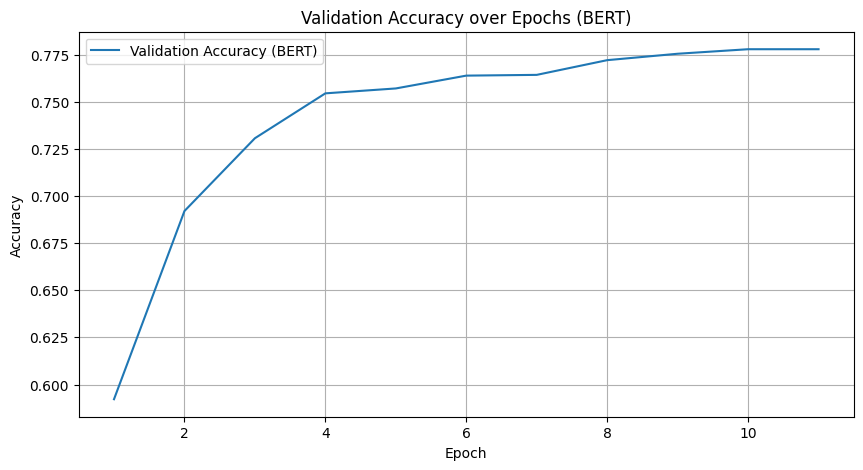

In [ ]:
# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs_bert, accuracy_bert, label='Validation Accuracy (BERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (BERT)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/accuracy_curve_bert.png")
plt.show()


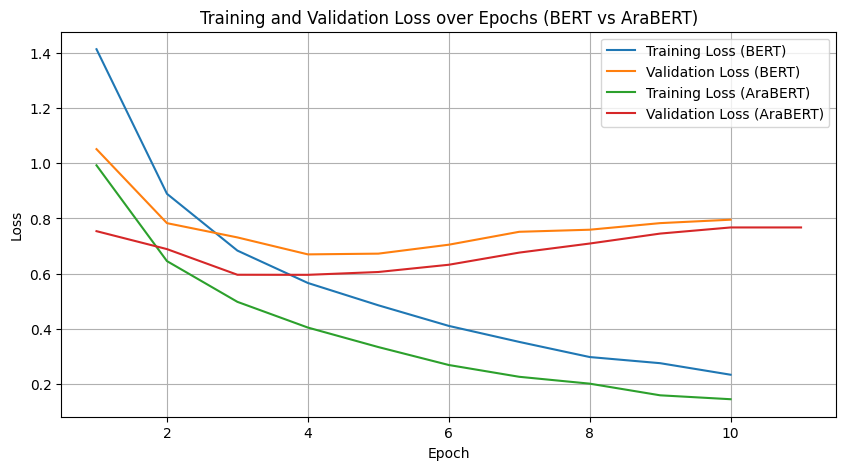

In [ ]:

# Plotting Training vs Evaluation Loss for both BERT and AraBERT
plt.figure(figsize=(10, 5))
plt.plot(train_epochs_bert, train_loss_bert, label='Training Loss (BERT)')
plt.plot(eval_epochs_bert[:10], eval_loss_bert[:10], label='Validation Loss (BERT)')  # Ensure same length
plt.plot(train_epochs, train_loss, label='Training Loss (AraBERT)')
plt.plot(eval_epochs, eval_loss, label='Validation Loss (AraBERT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs (BERT vs AraBERT)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/trainloss-compare.png")
plt.show()

AraBERT consistently outperforms BERT in terms of accuracy, starting from a higher baseline and achieving a peak accuracy of 81.14% compared to BERT's 77.78%. This suggests that AraBERT, being specifically tailored for Arabic, is better suited for the dialect classification task, resulting in superior performance and better generalization.

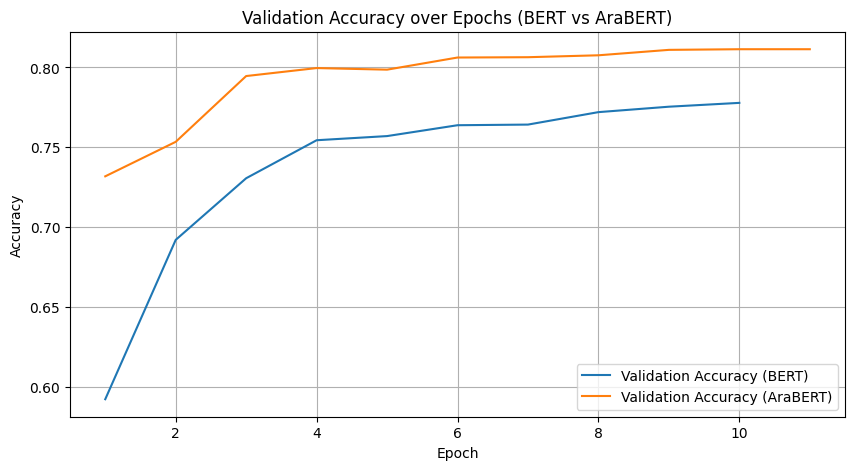

In [ ]:
# Plotting Validation Accuracy for both BERT and AraBERT
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs_bert, accuracy_bert, label='Validation Accuracy (BERT)')  # Ensure same length
plt.plot(eval_epochs, accuracy, label='Validation Accuracy (AraBERT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs (BERT vs AraBERT)')
plt.legend()
plt.grid(True)
plt.savefig("./drive/MyDrive/madar/accuracy-compare.png")

plt.show()

In [ ]:
# Extract precision, recall, and F1-score for BERT
precision_bert = [log['eval_precision'] for log in logs_bert if 'eval_precision' in log]
recall_bert = [log['eval_recall'] for log in logs_bert if 'eval_recall' in log]
f1_bert = [log['eval_f1'] for log in logs_bert if 'eval_f1' in log]

# Extract precision, recall, and F1-score for AraBERT
precision_arabert = [log['eval_precision'] for log in logs if 'eval_precision' in log]
recall_arabert = [log['eval_recall'] for log in logs if 'eval_recall' in log]
f1_arabert = [log['eval_f1'] for log in logs if 'eval_f1' in log]


AraBERT consistently shows higher validation precision across all epochs compared to BERT. For instance, in the final epoch, AraBERT achieves a precision of 0.8131, while BERT reaches only 0.7775, indicating that AraBERT is more accurate in identifying true positives out of all positive predictions.

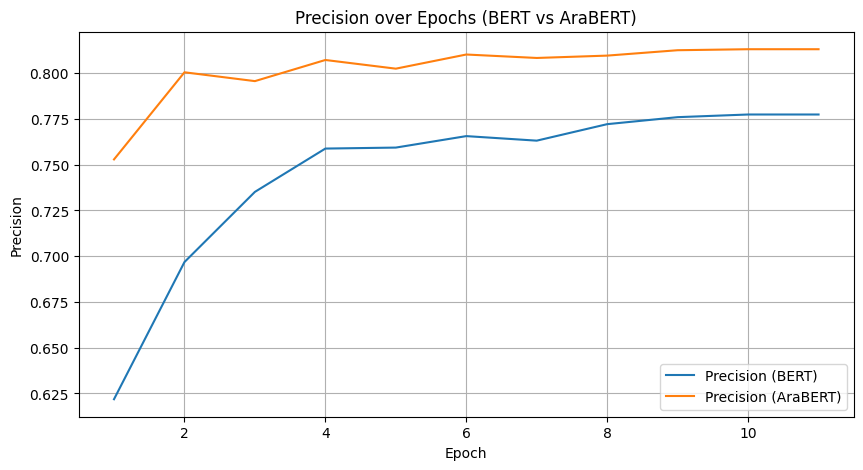

In [ ]:
import matplotlib.pyplot as plt

# Assuming you've already extracted the metrics
# Precision
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs_bert[:len(precision_bert)], precision_bert, label='Precision (BERT)')
plt.plot(eval_epochs[:len(precision_arabert)], precision_arabert, label='Precision (AraBERT)')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs (BERT vs AraBERT)')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/madar/precision_bert_Vs_arabert.png")

plt.show()

AraBERT demonstrates superior recall compared to BERT, particularly in the later epochs. By the final epoch, AraBERT reaches a recall of 0.8114, while BERT achieves 0.7778. This indicates that AraBERT is more effective at identifying true positives, capturing a higher proportion of actual positive instances than BERT.





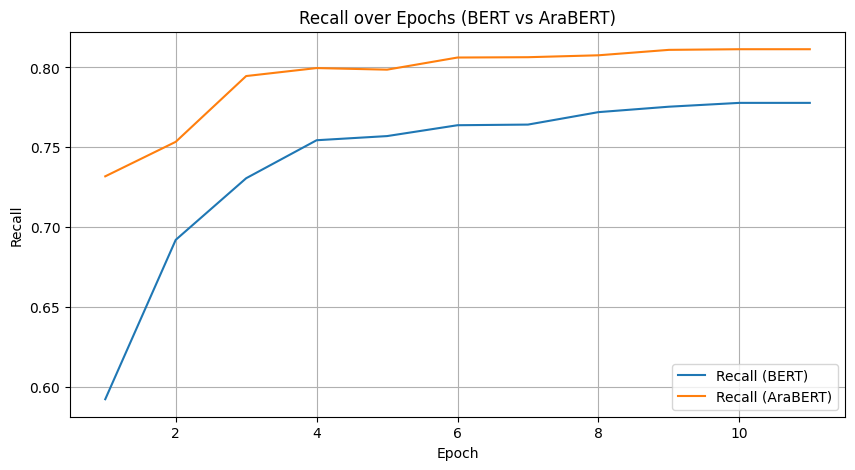

In [ ]:
# Recall
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs_bert[:len(recall_bert)], recall_bert, label='Recall (BERT)')
plt.plot(eval_epochs[:len(recall_arabert)], recall_arabert, label='Recall (AraBERT)')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs (BERT vs AraBERT)')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/madar/recall_bert_Vs_arabert.png")
plt.show()

AraBERT also outperforms BERT in terms of F1-score, with a final F1-score of 0.8120 compared to BERT's 0.7772. This demonstrates that AraBERT has a better balance between precision and recall, leading to more reliable overall performance in classification tasks.


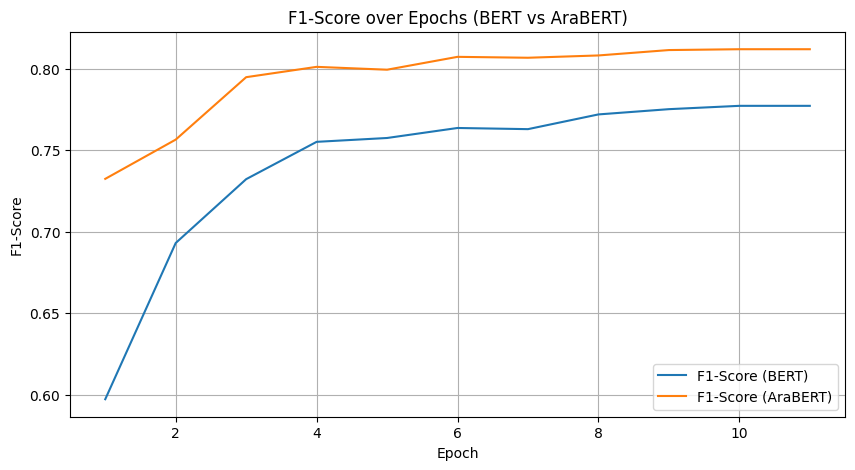

In [ ]:
# F1-Score
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs_bert[:len(f1_bert)], f1_bert, label='F1-Score (BERT)')
plt.plot(eval_epochs[:len(f1_arabert)], f1_arabert, label='F1-Score (AraBERT)')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score over Epochs (BERT vs AraBERT)')
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/madar/f1_bert_Vs_arabert.png")

plt.show()

**ChatGpt Results** <br>
ChatGpt was tested using propmts, the test sentences were sent to chatgpt4 and chatgpt 4o by propmt and it was asked to classify the dialects for the given classes.
here is a link to the chat: https://chatgpt.com/share/6486e5dc-d472-4f63-9123-7b6b0a93e6cb

In [ ]:
df_gpt4o = pd.read_excel('/content/drive/MyDrive/madar/chatgpt4oresult.xlsx')
df_gpt4 = pd.read_excel('/content/drive/MyDrive/madar/chatgpt4results.xlsx')
merged_gpt4o = pd.merge(test_df, df_gpt4o, on="CODA", how="right")
merged_gpt4 = pd.merge(test_df, df_gpt4o, on="CODA", how="right")
true_labels = merged_gpt4['label'].tolist()
gpt4_pred = merged_gpt4['pred'].tolist()
gpt4o_pred = merged_gpt4o['pred'].tolist()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Compute metrics for GPT-4
gpt4_accuracy = accuracy_score(true_labels, gpt4_pred)
gpt4_precision = precision_score(true_labels, gpt4_pred, average="weighted")
gpt4_recall = recall_score(true_labels, gpt4_pred, average="weighted")
gpt4_f1 = f1_score(true_labels, gpt4_pred, average="weighted")

# Compute metrics for GPT-4O
gpt4o_accuracy = accuracy_score(true_labels, gpt4o_pred)
gpt4o_precision = precision_score(true_labels, gpt4o_pred, average="weighted")
gpt4o_recall = recall_score(true_labels, gpt4o_pred, average="weighted")
gpt4o_f1 = f1_score(true_labels, gpt4o_pred, average="weighted")

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    "Model": ["GPT-4", "GPT-4O", "BERT", "AraBERT"],
    "Accuracy": [gpt4_accuracy, gpt4o_accuracy, 0.7778, 0.8114],  # Replace with actual BERT and AraBERT accuracy
    "Precision": [gpt4_precision, gpt4o_precision, 0.7775, 0.8131],  # Replace with actual BERT and AraBERT precision
    "Recall": [gpt4_recall, gpt4o_recall, 0.7778, 0.8114],  # Replace with actual BERT and AraBERT recall
    "F1-Score": [gpt4_f1, gpt4o_f1, 0.7772, 0.8120]  # Replace with actual BERT and AraBERT F1-score
})

# Display the table
print(results_df)


     Model  Accuracy  Precision    Recall  F1-Score
0    GPT-4  0.229642   0.389751  0.229642  0.155059
1   GPT-4O  0.229642   0.389751  0.229642  0.155059
2     BERT  0.777800   0.777500  0.777800  0.777200
3  AraBERT  0.811400   0.813100  0.811400  0.812000


### Takeaways and Comparison:

1. **Performance of GPT-4 and GPT-4O:**
   - GPT-4 and GPT-4O performed the same, with both hitting an accuracy of **22.96%** and an F1-score of **15.51%**. This shows that they struggle with classifying Arabic dialects when directly asked. Their low precision, recall, and F1-scores suggest they’re having a hard time correctly identifying and distinguishing between the dialects.

2. **Performance of BERT:**
   - BERT does much better than both GPT-4 and GPT-4O, scoring **77.78%** accuracy and an F1-score of **77.72%**. Even though BERT wasn’t specifically fine-tuned for Arabic dialects like AraBERT, it’s still far more effective at this task than the general-purpose GPT models.

3. **Performance of AraBERT:**
   - AraBERT comes out on top with an accuracy of **81.14%** and an F1-score of **81.20%**. This makes sense since AraBERT was designed with Arabic in mind, and it clearly outperforms both GPT variants and BERT in classifying dialects.

4. **GPT-4 vs. BERT/AraBERT:**
   - There’s a big difference in performance between GPT-4/GPT-4O and the fine-tuned models like BERT and AraBERT. While GPT-4 is great for general tasks, it lacks the specialized training needed for something as specific as Arabic dialect classification.

5. **General Implication:**
   - These results show that while models like GPT-4 can do a lot, they might not be the best for specialized tasks without fine-tuning. For something like Arabic dialect classification, models that are specifically designed and trained for Arabic, like AraBERT, are much more effective.

### Summary:
AraBERT, being fine-tuned for Arabic, is the best at dialect classification, with BERT following behind. General-purpose models like GPT-4 and GPT-4O, without specific training, fall short in this task. This comparison highlights the importance of using task-specific models for achieving high accuracy and reliability in specialized tasks.

Pre-trained Arabert and Bert Classification

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from datasets import load_metric

# Load the models and tokenizers
arabert_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
arabert_model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=5)

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=5)

# Tokenize the test data
test_texts = test_df['CODA'].tolist()
test_labels = test_df['label'].tolist()

arabert_encodings = arabert_tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
bert_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Create a DataLoader
class ArabicDialectDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

arabert_dataset = ArabicDialectDataset(arabert_encodings, test_labels)
bert_dataset = ArabicDialectDataset(bert_encodings, test_labels)

arabert_loader = DataLoader(arabert_dataset, batch_size=16)
bert_loader = DataLoader(bert_dataset, batch_size=16)

# Evaluation function to calculate all metrics
def evaluate(model, loader):
    model.eval()
    accuracy_metric = load_metric("accuracy")
    precision_metric = load_metric("precision")
    recall_metric = load_metric("recall")
    f1_metric = load_metric("f1")

    all_predictions = []
    all_labels = []

    for batch in loader:
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_metric.compute(predictions=all_predictions, references=all_labels)
    precision = precision_metric.compute(predictions=all_predictions, references=all_labels, average="weighted")
    recall = recall_metric.compute(predictions=all_predictions, references=all_labels, average="weighted")
    f1 = f1_metric.compute(predictions=all_predictions, references=all_labels, average="weighted")

    return accuracy["accuracy"], precision["precision"], recall["recall"], f1["f1"]

# Evaluate AraBERT (pre-trained)
arabert_accuracy, arabert_precision, arabert_recall, arabert_f1 = evaluate(arabert_model, arabert_loader)
print(f"AraBERT (pre-trained) Accuracy: {arabert_accuracy:.6f}")
print(f"AraBERT (pre-trained) Precision: {arabert_precision:.6f}")
print(f"AraBERT (pre-trained) Recall: {arabert_recall:.6f}")
print(f"AraBERT (pre-trained) F1-Score: {arabert_f1:.6f}")

# Evaluate BERT (pre-trained)
bert_accuracy, bert_precision, bert_recall, bert_f1 = evaluate(bert_model, bert_loader)
print(f"BERT (pre-trained) Accuracy: {bert_accuracy:.6f}")
print(f"BERT (pre-trained) Precision: {bert_precision:.6f}")
print(f"BERT (pre-trained) Recall: {bert_recall:.6f}")
print(f"BERT (pre-trained) F1-Score: {bert_f1:.6f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-7aaeb9f9f343>:43: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AraBERT (pre-trained) Accuracy: 0.201200
AraBERT (pre-trained) Precision: 0.185583
AraBERT (pre-trained) Recall: 0.201200
AraBERT (pre-trained) F1-Score: 0.069988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BERT (pre-trained) Accuracy: 0.204000
BERT (pre-trained) Precision: 0.129793
BERT (pre-trained) Recall: 0.204000
BERT (pre-trained) F1-Score: 0.116639


Performance Comparisson